In [19]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [20]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
tf.config.list_physical_devices('GPU')

[]

In [175]:
import os
import imghdr
from PIL import Image
import tensorflow as tf

image_exts = ['jpeg', 'jpg']
train_dir = "Training and Validation"

def remove_corrupted_images(data_dir):
    if not os.path.isdir(data_dir):
        print(f"Provided path {data_dir} is not a directory")
        return
    
    for image_class in os.listdir(data_dir):
        class_path = os.path.join(data_dir, image_class)
        if not os.path.isdir(class_path):
            continue
        
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            if imghdr.what(image_path) not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
                continue
            
            # Check if the image can be loaded with PIL and decoded with TensorFlow
            if not is_image_valid(image_path):
                print(f'Removing corrupted or undecodable image {image_path}')
                os.remove(image_path)

def is_image_valid(filename):
    try:
        # Use PIL to verify the image
        with Image.open(filename) as img:
            img.verify()
        
        # Use TensorFlow to decode the image
        image_string = tf.io.read_file(filename)
        tf.image.decode_jpeg(image_string, channels=3)  # This will throw an error if the image cannot be decoded
        return True
    except (IOError, tf.errors.InvalidArgumentError):
        return False


In [176]:
remove_corrupted_images(train_dir)

In [178]:
data = tf.keras.utils.image_dataset_from_directory('Training and Validation')

Found 1832 files belonging to 2 classes.


In [179]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

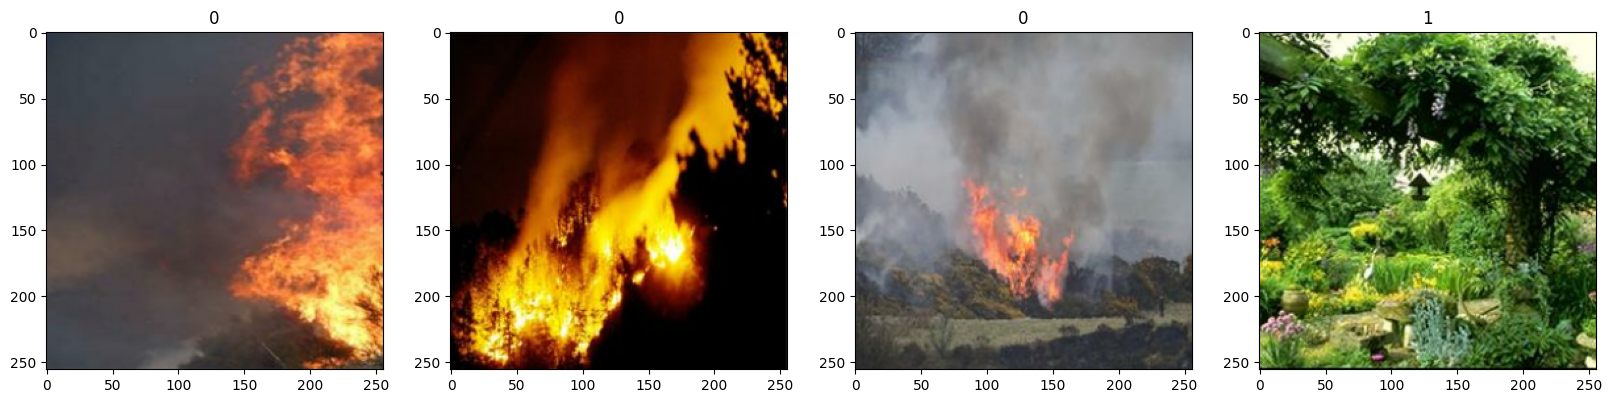

In [180]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [181]:
data.as_numpy_iterator().next()

(array([[[[2.14000000e+02, 2.04000000e+02, 1.45000000e+02],
          [1.58039062e+02, 1.47074219e+02, 9.09687500e+01],
          [1.31523438e+02, 1.18640625e+02, 6.54648438e+01],
          ...,
          [1.12957031e+02, 1.03957031e+02, 8.88398438e+01],
          [5.04257812e+01, 4.14257812e+01, 2.44257812e+01],
          [1.17000000e+02, 1.08000000e+02, 9.10000000e+01]],
 
         [[1.81195312e+02, 1.71195312e+02, 1.12195312e+02],
          [1.69918701e+02, 1.58953857e+02, 1.02848389e+02],
          [1.66830688e+02, 1.53947876e+02, 1.00772095e+02],
          ...,
          [4.53162079e+01, 3.63162079e+01, 2.13120880e+01],
          [1.65543701e+02, 1.56543701e+02, 1.41405548e+02],
          [1.87433594e+02, 1.78433594e+02, 1.61433594e+02]],
 
         [[1.68703125e+02, 1.58703125e+02, 9.97031250e+01],
          [1.66321167e+02, 1.55356323e+02, 9.92508545e+01],
          [1.77645248e+02, 1.64762436e+02, 1.11586655e+02],
          ...,
          [1.50013748e+02, 1.40182663e+02, 1.2795

In [182]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [183]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [184]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [185]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [186]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [187]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 16)       

In [188]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
40/40 [==============================] - 25s 604ms/step - loss: 11.5977 - accuracy: 0.8000 - val_loss: 0.3011 - val_accuracy: 0.8608
Epoch 2/20
40/40 [==============================] - 27s 659ms/step - loss: 0.3479 - accuracy: 0.8852 - val_loss: 0.3471 - val_accuracy: 0.9460
Epoch 3/20
40/40 [==============================] - 27s 683ms/step - loss: 0.1804 - accuracy: 0.9312 - val_loss: 0.3451 - val_accuracy: 0.9290
Epoch 4/20
40/40 [==============================] - 27s 671ms/step - loss: 0.1140 - accuracy: 0.9742 - val_loss: 0.2495 - val_accuracy: 0.9403
Epoch 5/20
40/40 [==============================] - 25s 633ms/step - loss: 0.0716 - accuracy: 0.9820 - val_loss: 0.2117 - val_accuracy: 0.9375
Epoch 6/20
40/40 [==============================] - 25s 618ms/step - loss: 0.0554 - accuracy: 0.9898 - val_loss: 0.2875 - val_accuracy: 0.9460
Epoch 7/20
40/40 [==============================] - 25s 618ms/step - loss: 0.0405 - accuracy: 0.9930 - val_loss: 0.3088 - val_accuracy: 0.957

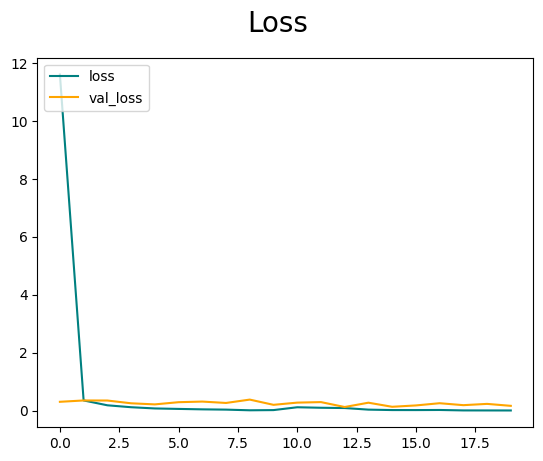

In [189]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

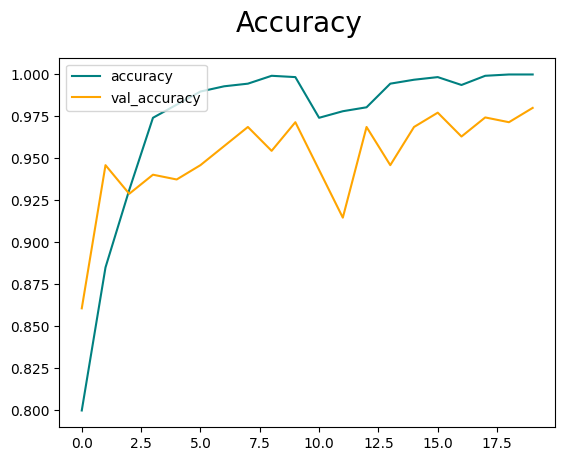

In [190]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [191]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [192]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [193]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 0s 86ms/step
tf.Tensor(0.95348835, shape=(), dtype=float32) tf.Tensor(0.9647059, shape=(), dtype=float32) tf.Tensor(0.95625, shape=(), dtype=float32)


TypeError: Image data of dtype object cannot be converted to float

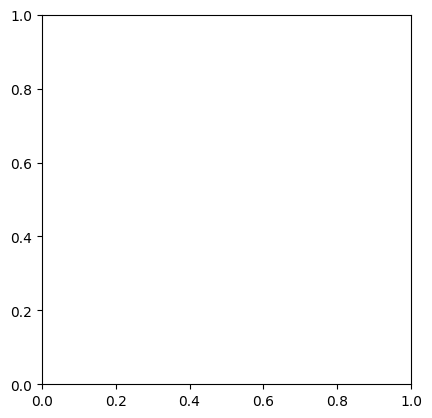

In [203]:
import cv2
img = cv2.imread('Training and Validation/nofire/abc198.jpg')
plt.imshow(img)

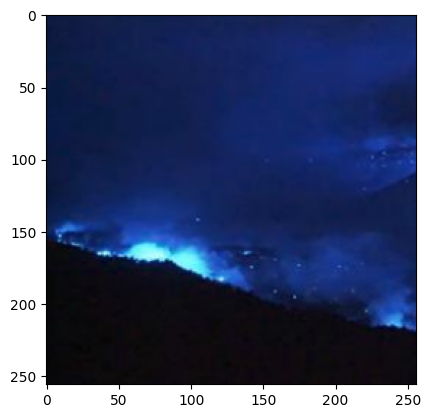

In [199]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [201]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 30ms/step


array([[0.47356772]], dtype=float32)

In [161]:
from tensorflow.keras.models import load_model
model.save("wildfire.h5")
new_model = load_model('wildfire.h5')
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 59ms/step


array([[0.9348178]], dtype=float32)

In [163]:
def loadImage(filepath):
    img = cv2.imread(filepath)
    resize = tf.image.resize(img, (256,256))
    return np.expand_dims(resize/255, 0)

In [174]:
new_model.predict(loadImage("images.jpg"))

1/1 [==============================] - 0s 19ms/step


array([[0.9605466]], dtype=float32)